In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## PART I: Theory Questions

### Maximum Likelihood Estimate (MLE) Answers


#### Answer I

Let the probability of getting head is P(H). 
Since there are 3 heads in 5 coin flips, the P(H) = 3/5 which is 0.6. This value is equal to MLE.

#### Answer II

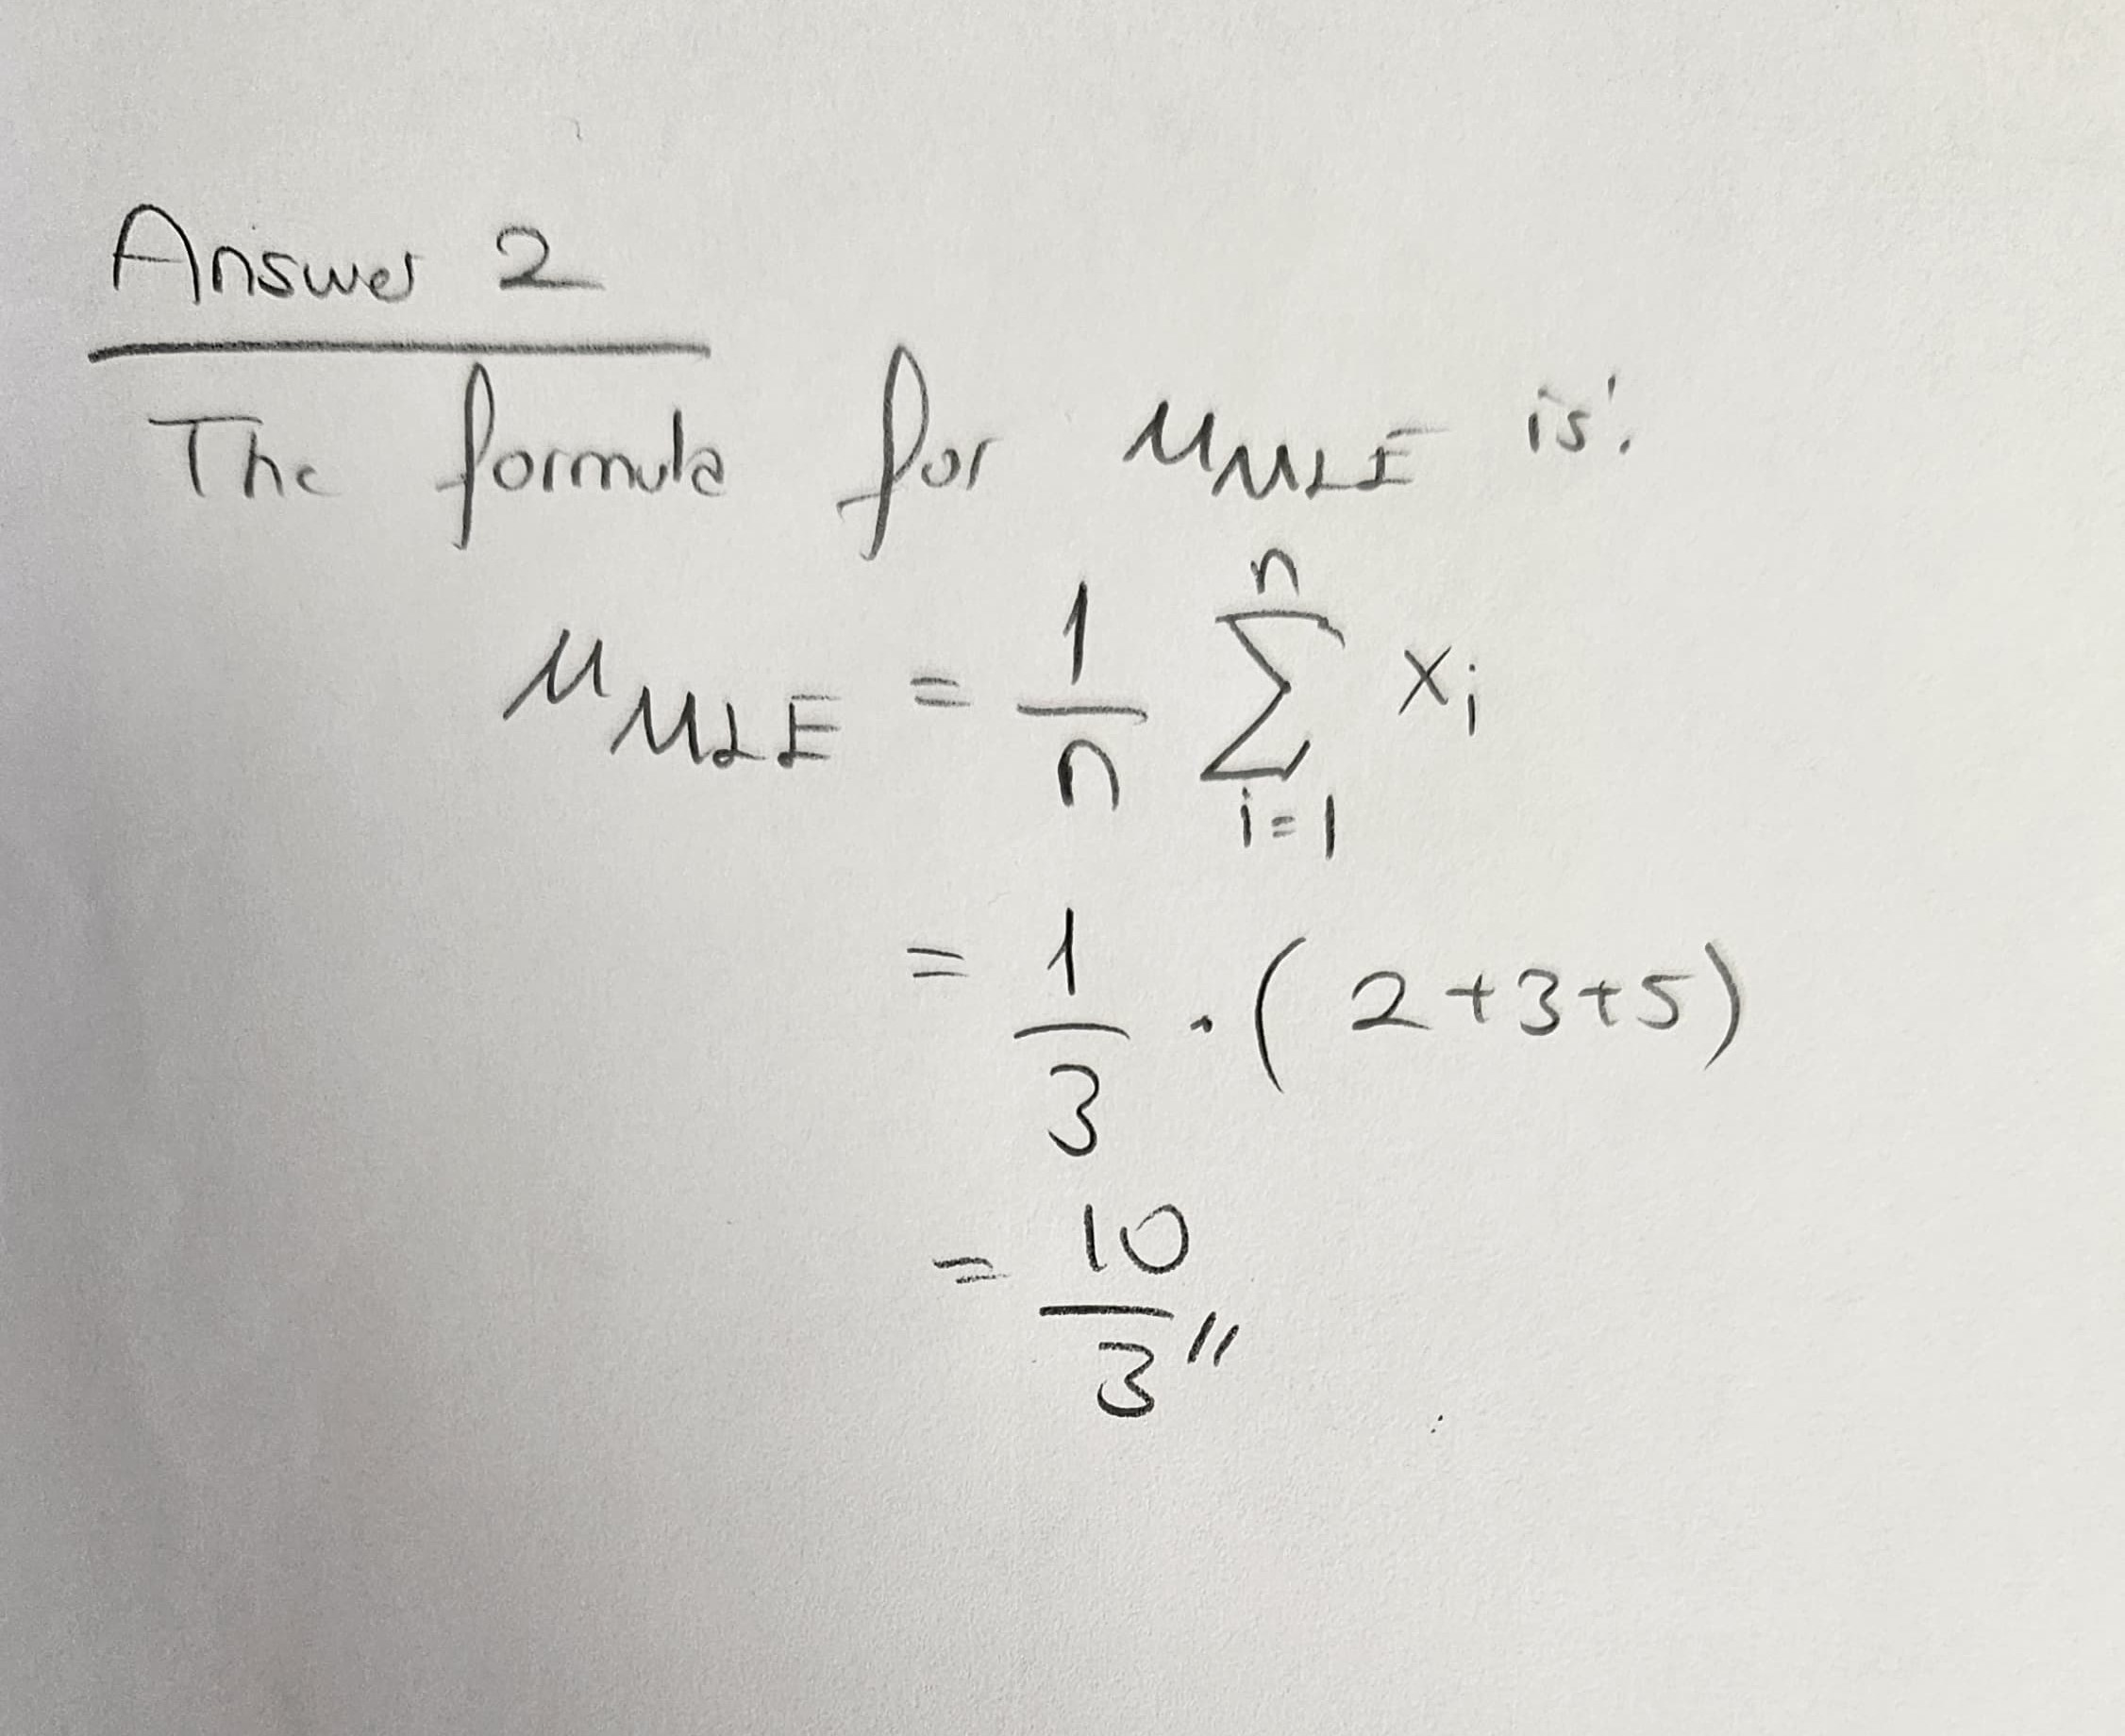

#### Answer III

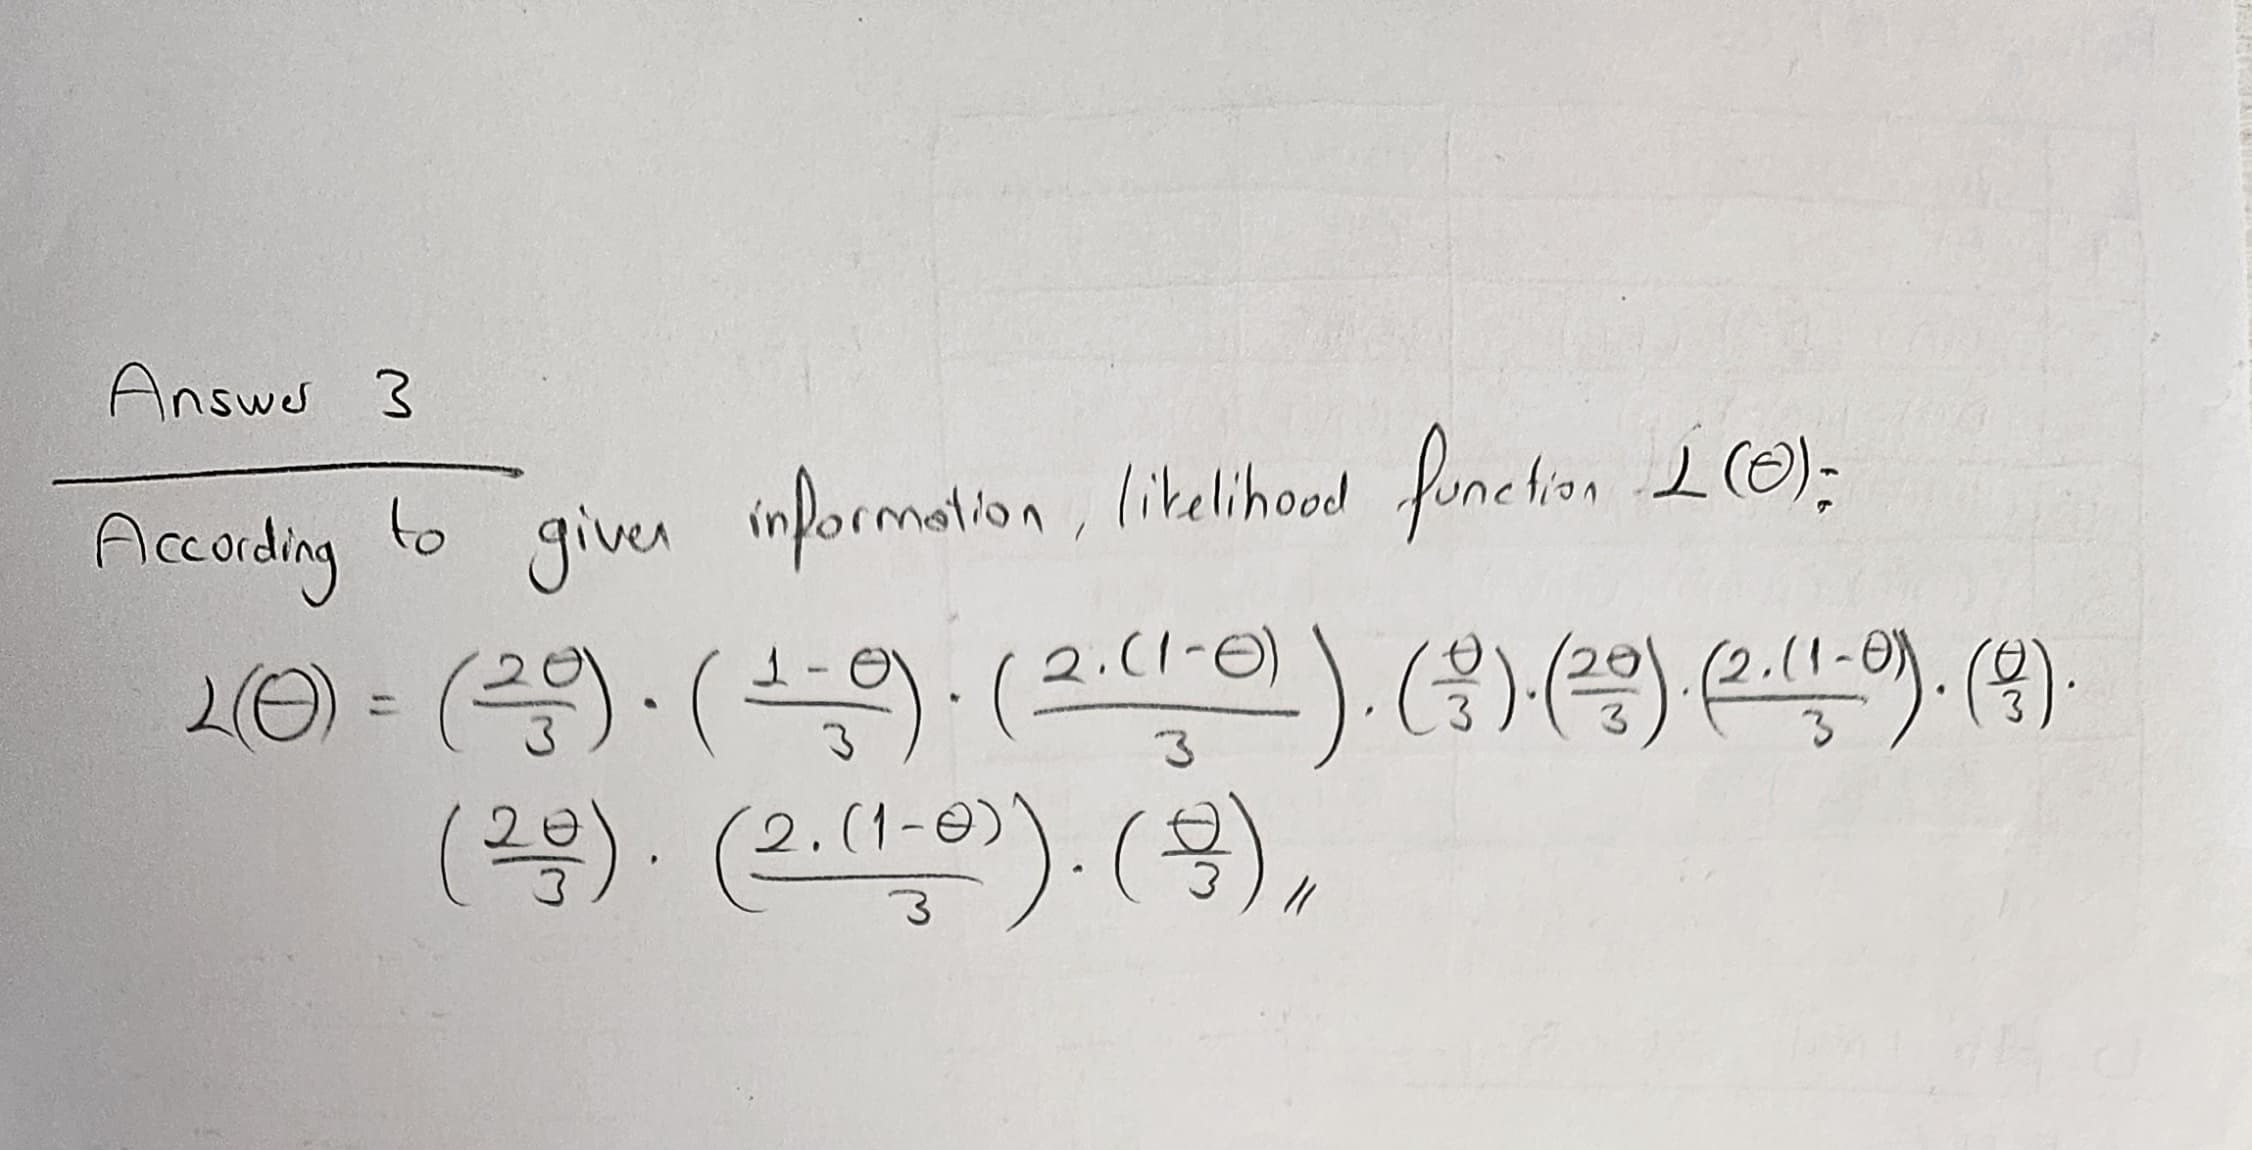

#### Answer IV 

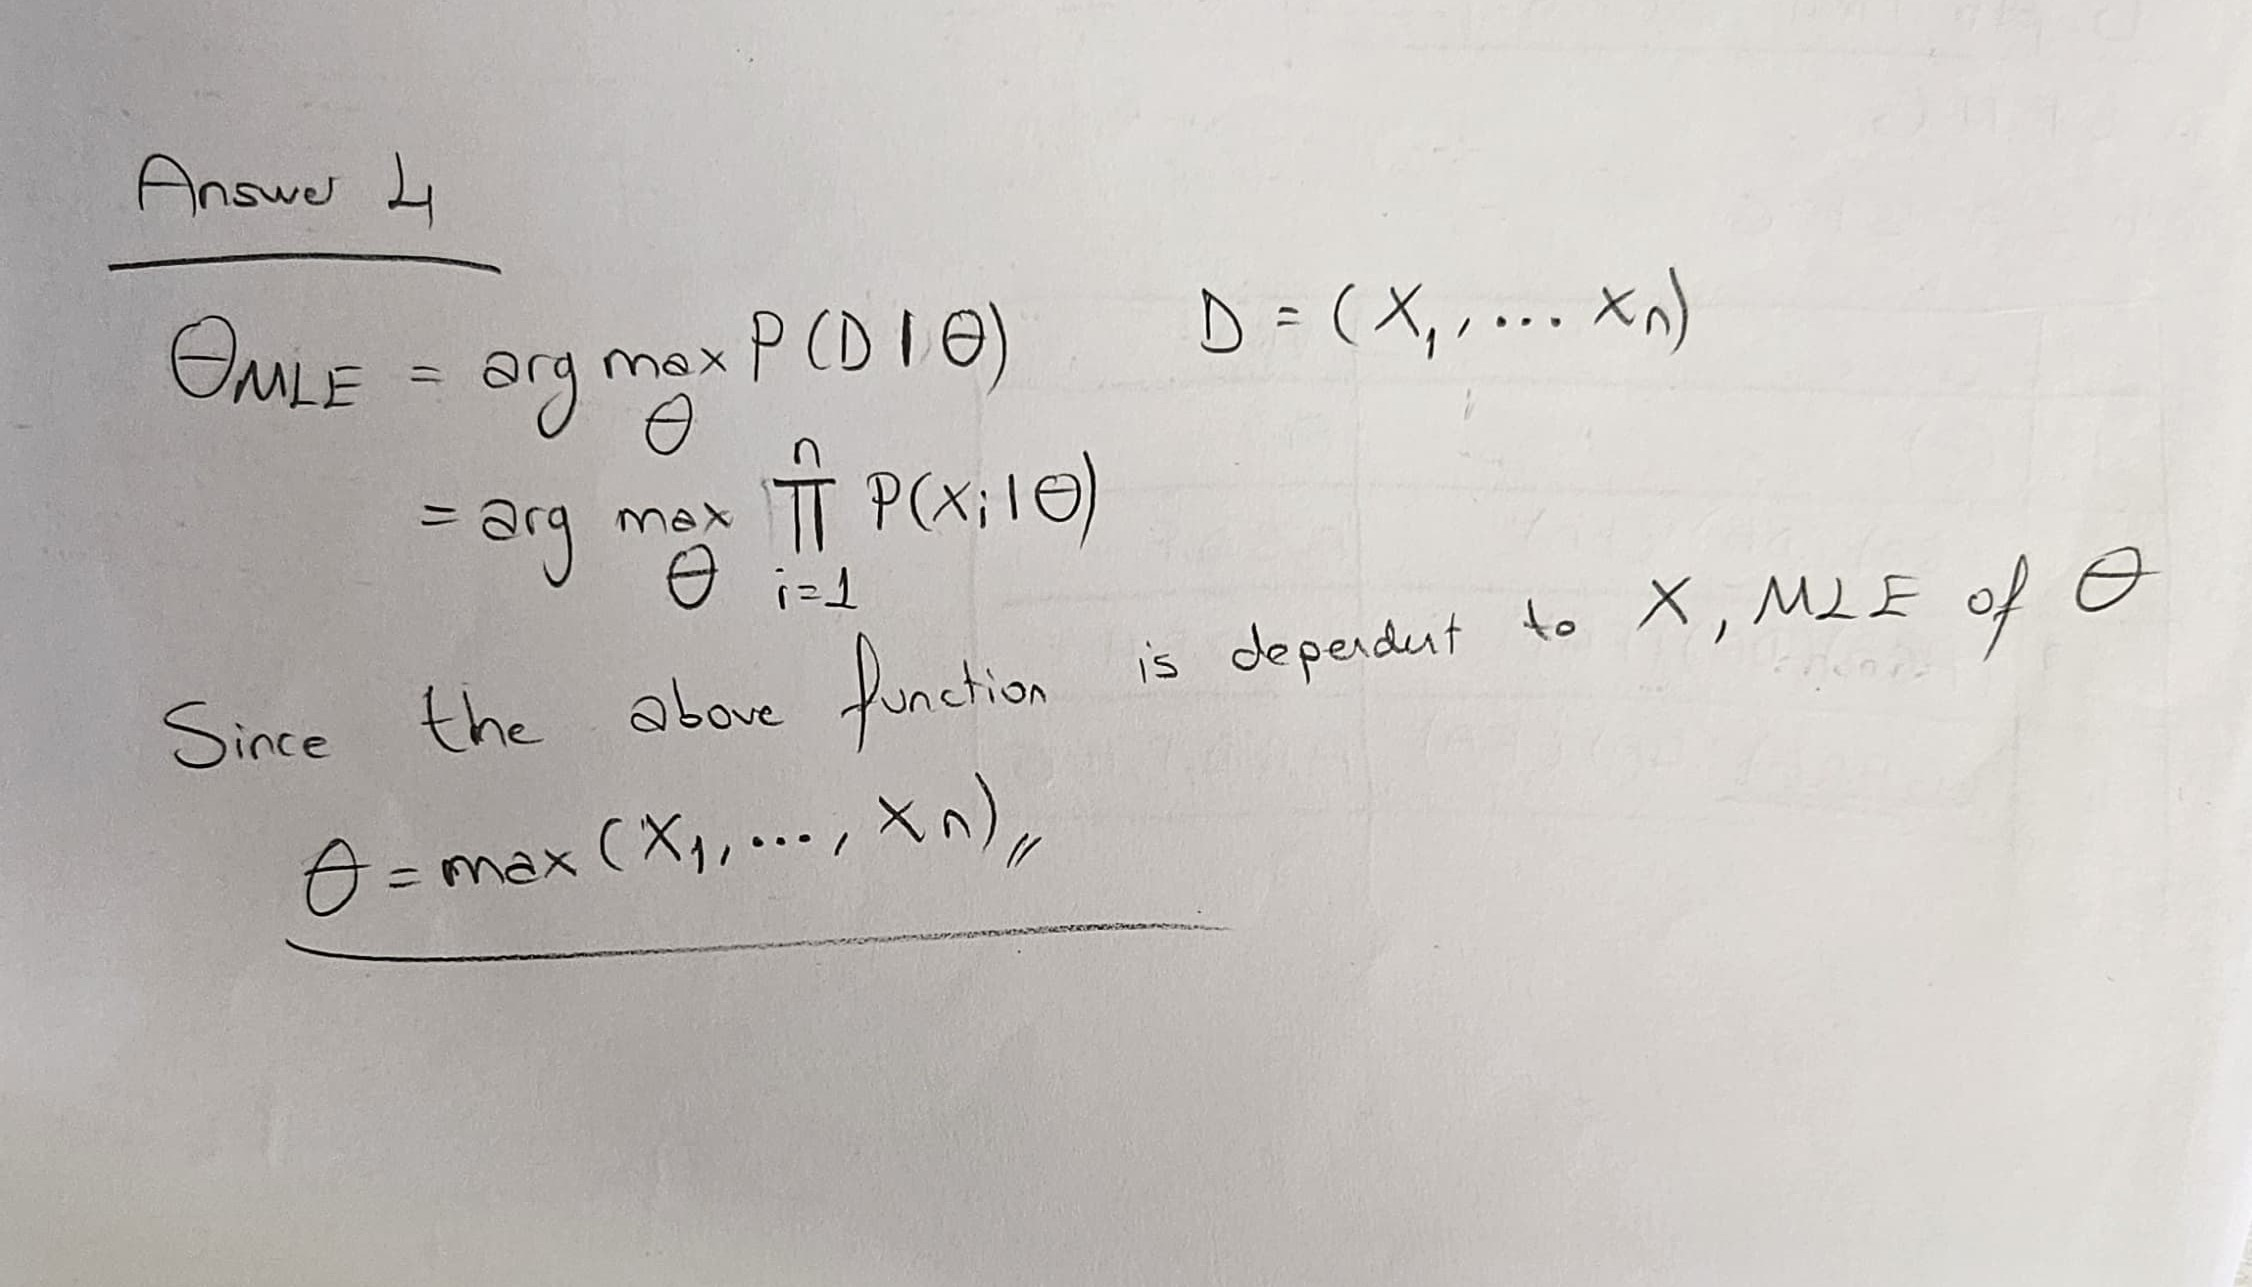

### Naive Bayes

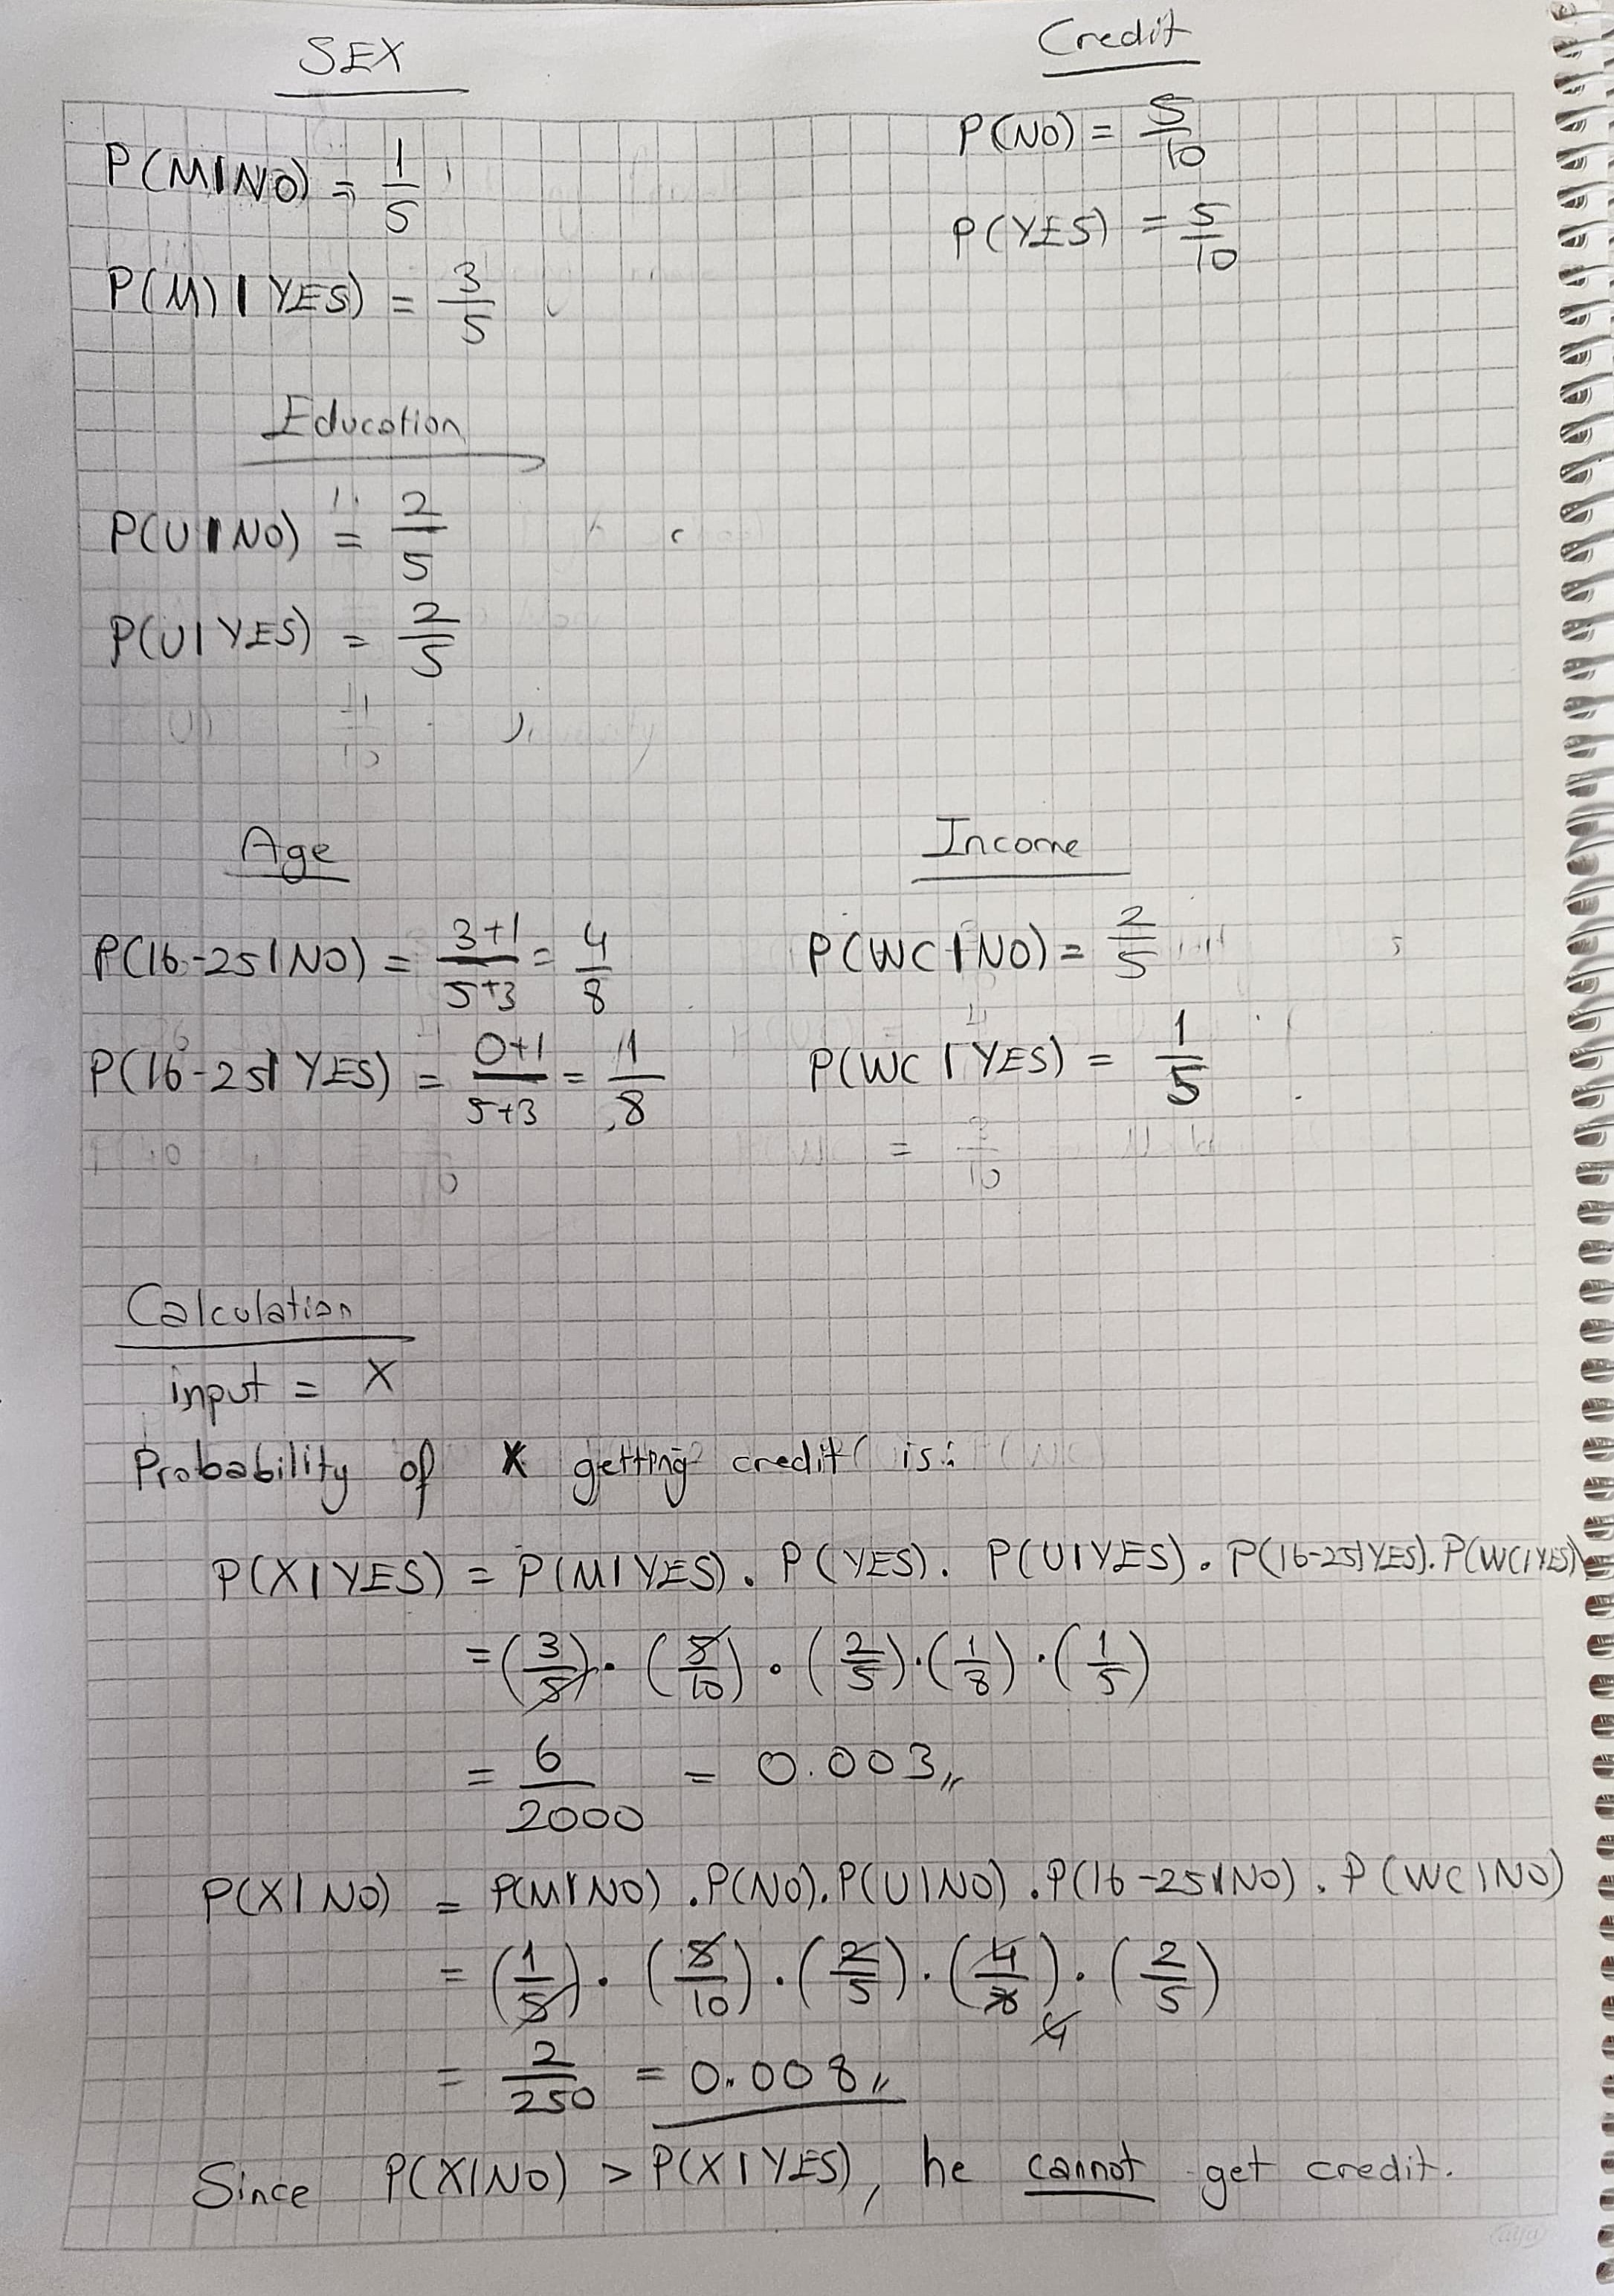

## PART II:  Semantic Segmentation of Multispectral Images

In [2]:
classes = np.load("D:AIN313/ASM2/classes.npy")
print(classes)

['0. Other Class/Image Border' '1. Road Markings, Asphalt, Landing Pad'
 '2. Water' '3. Building' '4. Vehicle (Car, Truck, or Bus)' '5. Person'
 '6. Vegetation' '7. Wood Panel' '8. Rocks, Sand' '9. Chair, Table']


In [3]:
train_data = np.load("D:AIN313/ASM2/train_data.npy")
train_labels = np.load("D:AIN313/ASM2/train_labels.npy")
train_mask = np.load("D:AIN313/ASM2/train_mask.npy")

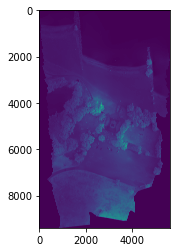

In [4]:
plt.imshow(train_data[:,:,5])

In [5]:
print(train_mask.shape)

(9393, 5642)


In [6]:
np.unique(train_mask)

array([    0, 65535], dtype=uint16)

In [7]:
# train_data = train_data - train_mask[:, :, np.newaxis]
# train_labels = train_data -
# row_indices, col_indices = np.where(train_mask != 0)
# print(len(row_indices), len(col_indices))
# result_image_array = train_data[row_indices,col_indices, :]
# result_image_array = result_image_array.reshape(mask.sum(), 1, train_data.shape[2])
# mask = (train_mask != 0)
# print(mask.shape)
# print(mask)
# print(img_arr.shape)
# new_train = []
# for i in range(train_data.shape[2]):
#     masked_arr = np.where(train_data[:,:,i],train_mask!=0)
#     new_train.append(masked_arr)
# new_train = np.array(new_train)
# new_train = np.transpose(new_train, (1, 2, 0))
# print(new_train.shape)
mask_6d = np.stack((train_mask,train_mask,train_mask,train_mask,train_mask,train_mask),axis =2)

train_data = train_data * mask_6d

# If you want to keep the same dimensions, you can use np.where to fill non-matching values with 0
# resulting_array = np.where(train_mask[..., None], train_data, 0)

In [8]:
# train_data = np.where((train_mask[:, :, np.newaxis] == 0), np.nan, train_data)

In [9]:
train_data.shape

(9393, 5642, 6)

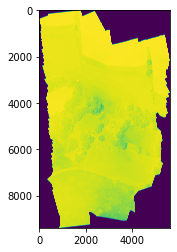

In [10]:
plt.imshow(train_data[:,:,5])

In [11]:
class GNB:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.parameters = []
        self.y = y

        for c in self.classes:
            X_c = X[y == c]
            self.parameters.append((X_c.mean(axis=0), X_c.std(axis=0)))

    def calculate_likelihood(self, x, mean, std):
        exp = np.exp(-((x - mean) ** 2) / (2 * (std ** 2)))
        return (1 / (np.sqrt(2 * np.pi) * std)) * exp

    def calculate_prior(self, c, y):
        return len(y[y == c]) / len(y)

    def predict(self, X):
        num_samples, height, width = X.shape
        num_classes = len(self.classes)

        # Calculate likelihood for each class using vectorized operations
        class_scores = np.zeros((num_samples, height, num_classes))

        for j, c in enumerate(self.classes):
            mean, std = self.parameters[j]
            log_likelihood = np.log(self.calculate_likelihood(X, mean, std))
            prior = np.log(self.calculate_prior(c, self.y))
            class_scores[:, :, j] = prior + np.sum(log_likelihood, axis=-1)

        # Find the index of the class with the highest score for each pixel
        segmentations = np.argmax(class_scores, axis=-1)
        return segmentations

### Accuracy Function

In [73]:
def accuracy(preds, truth):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    conf_matrix = np.zeros((10,10))
    for i in range(10):
        conf_matrix[i][i] = np.sum(np.logical_and(preds == i, truth == i))
        for j in range(10):
            if (i == j):
                continue
            else:
                conf_matrix[i][j] = np.sum(np.logical_and(preds== i, truth == j))
    for i in range(10):
            TP = conf_matrix[i, i]
            FN = np.sum(conf_matrix[i, :]) - TP # The sum of values of corresponding rows except for the TP value
            FP = np.sum(conf_matrix[:, i]) - TP # The sum of values of the corresponding column except for the TP value.
            TN = np.sum(conf_matrix) - TP - FN - FP # The sum of values of all columns and rows except the values of that
                                                    # class that we are calculating the values for.  
            tp+= TP
            tn+= TN
            fp+= FP
            fn+= FN                                          
    accuracy = (tp + tn) / (tp + tn + fp + fn)        
    return accuracy                                       

In [14]:
def divide_data(x_data):
    if(len(x_data.shape) == 3):
        x_train_shape = (x_data.shape[0], 4230, x_data.shape[2])
        x_test_shape = (x_data.shape[0], 1412, x_data.shape[2])

        x_train = x_data[:, :x_train_shape[1], :]
        x_test = x_data[:, x_train_shape[1]:x_train_shape[1] + x_test_shape[1], :]
    elif(len(x_data.shape) == 2):
        x_train_shape = (x_data.shape[0], 4230)
        x_test_shape = (x_data.shape[0], 1412)

        x_train = x_data[:, :x_train_shape[1]]
        x_test = x_data[:, x_train_shape[1]:x_train_shape[1] + x_test_shape[1]]
    
    return x_train,x_test

In [15]:
x_train,x_test = divide_data(train_data) # %25 of every image is chosen as test.

In [16]:
x_train_labels,x_test_labels = divide_data(train_labels)

### STEP I: Classify objects with Naive Bayes for each spectral image

In [17]:
data_split_train = np.split(x_train, 6, axis=2)
x_train_1 = data_split_train[0]
x_train_2 = data_split_train[1]
x_train_3 = data_split_train[2]
x_train_4 = data_split_train[3]
x_train_5 = data_split_train[4]
x_train_6 = data_split_train[5]

data_split_test = np.split(x_test, 6, axis =2)
x_test_1 = data_split_test[0]
x_test_2 = data_split_test[1]
x_test_3 = data_split_test[2]
x_test_4 = data_split_test[3]
x_test_5 = data_split_test[4]
x_test_6 = data_split_test[5]

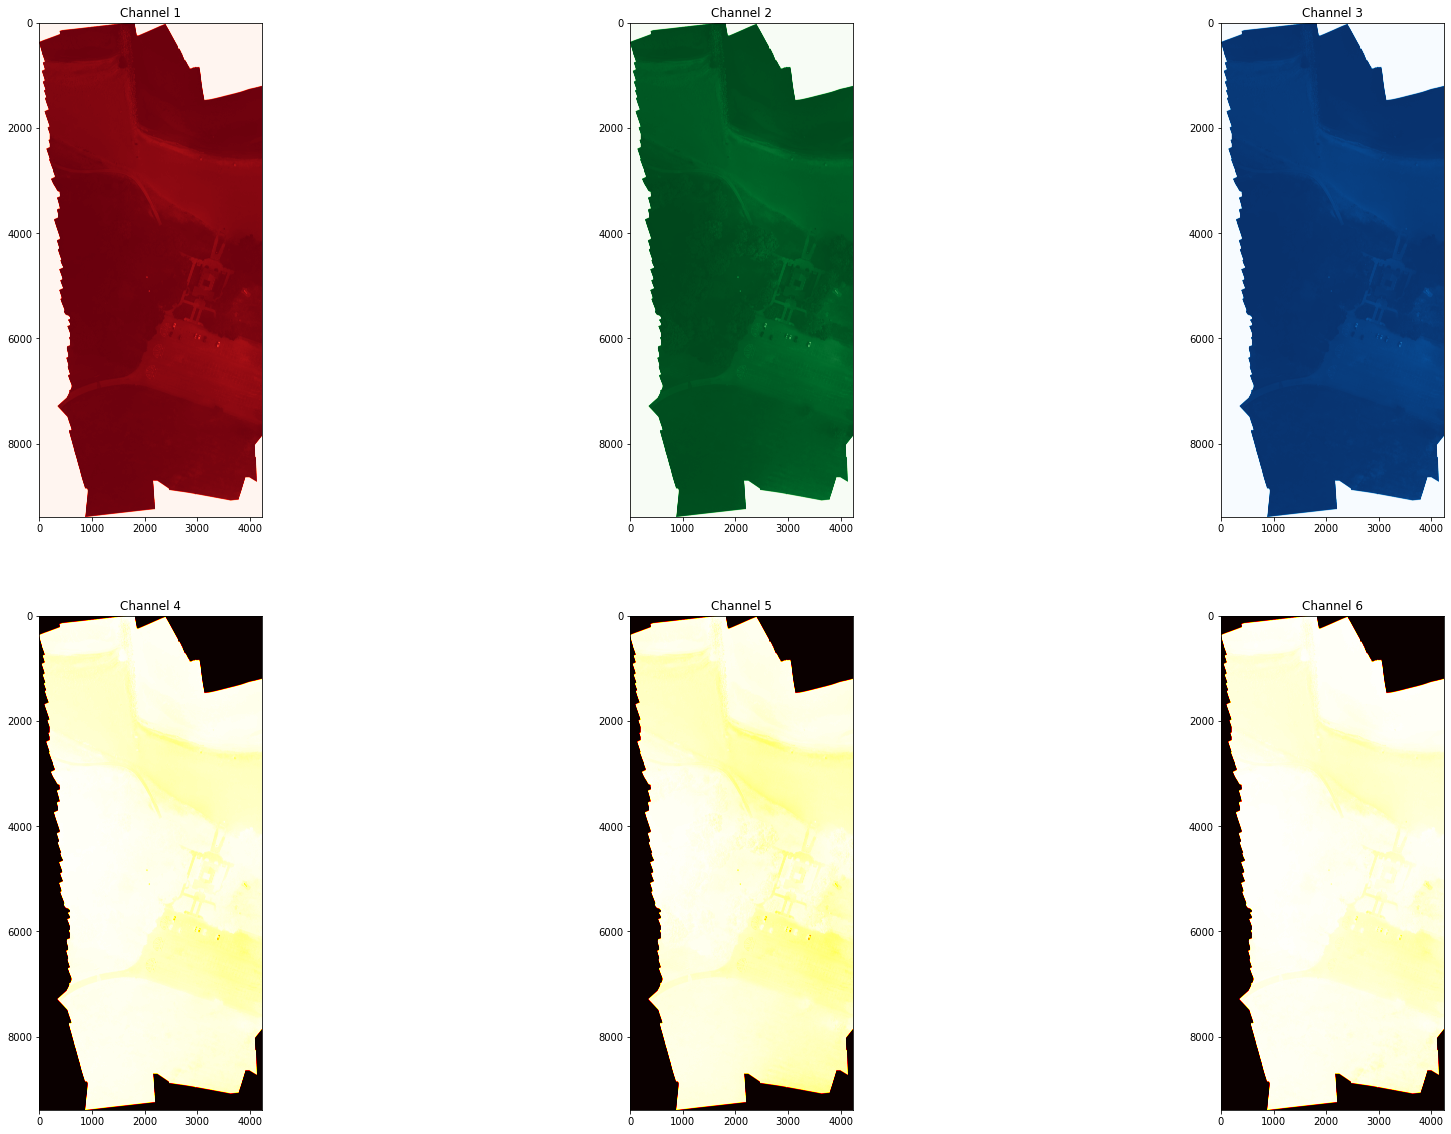

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(30, 20))
cmaps = ["Reds","Greens","Blues","hot","hot","hot"]
j=0
k=0
for i in range(6):
    if(i>=3):
        i = i% 3
    axes[j][i].imshow(data_split_train[i], cmap=cmaps[k])
    axes[j][i].set_title(f'Channel {k + 1}')
    if(i ==2):
     j+=1
    k+=1
plt.show()

In [19]:
model = GNB()

In [20]:
model = GNB()
model.fit(x_train_1,x_train_labels)
accuracies = {"Accuracy for spectra 1" : 0,
              "Accuracy for spectra 2" : 0,
              "Accuracy for spectra 3" : 0,
              "Accuracy for spectra 4" : 0,
              "Accuracy for spectra 5" : 0,
              "Accuracy for spectra 6" : 0,
              "Accuracy for spectra RGB" : 0,
              "Accuracy for spectra InfraRed" : 0,
              "Accuracy for spectra ALL" : 0}

In [21]:
print(np.unique(x_test_labels))

[0 1 2 4 5 6 8 9]


In [22]:
predictions = model.predict(x_test_1)
accuracies["Accuracy for spectra 1"] = accuracy(predictions, x_test_labels)

<ipython-input-11-0bae2b4de62e>:39: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(self.calculate_likelihood(X, mean, std))


In [23]:
unique, counts = np.unique(predictions, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5966617, 1: 237474, 4: 3707, 6: 4788465, 8: 2266653}


In [24]:
model.fit(x_train_2,x_train_labels)
predictions_2 = model.predict(x_test_2)
accuracies["Accuracy for spectra 2"] = accuracy(predictions_2, x_test_labels)

<ipython-input-11-0bae2b4de62e>:39: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(self.calculate_likelihood(X, mean, std))


In [25]:
unique, counts = np.unique(predictions_2, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5966788, 1: 190438, 2: 707727, 4: 2152, 6: 4796876, 8: 1598935}


In [26]:
model.fit(x_train_3,x_train_labels)
predictions_3 = model.predict(x_test_3)
accuracies["Accuracy for spectra 3"] = accuracy(predictions_3, x_test_labels)

<ipython-input-11-0bae2b4de62e>:39: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(self.calculate_likelihood(X, mean, std))


In [27]:
unique, counts = np.unique(predictions_3, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5966290, 1: 183442, 2: 1434855, 4: 1659, 6: 3580219, 8: 2096451}


In [28]:
model.fit(x_train_4,x_train_labels)
predictions_4 = model.predict(x_test_4)
accuracies["Accuracy for spectra 4"] = accuracy(predictions_4, x_test_labels)

<ipython-input-11-0bae2b4de62e>:39: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(self.calculate_likelihood(X, mean, std))


In [29]:
unique, counts = np.unique(predictions_4, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5966365, 2: 1640429, 6: 3701685, 8: 1954437}


In [30]:
model.fit(x_train_5,x_train_labels)
predictions_5 = model.predict(x_test_5)
accuracies["Accuracy for spectra 5"] = accuracy(predictions_5, x_test_labels)

<ipython-input-11-0bae2b4de62e>:39: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(self.calculate_likelihood(X, mean, std))


In [31]:
unique, counts = np.unique(predictions_5, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5966283, 2: 2042251, 6: 2325327, 8: 2929055}


In [32]:
model.fit(x_train_6,x_train_labels)
predictions_6 = model.predict(x_test_6)
accuracies["Accuracy for spectra 6"] = accuracy(predictions_6, x_test_labels)

<ipython-input-11-0bae2b4de62e>:39: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(self.calculate_likelihood(X, mean, std))


In [33]:
unique, counts = np.unique(predictions_6, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5966226, 2: 2011680, 6: 2566074, 8: 2718936}


In [34]:
print(x_test_6.shape)

(9393, 1412, 1)


### Applying GNB for RGB and Infrared Spectras

In [35]:
rgb_data_train = x_train[:, :, :3]
infra_data_train = x_train[:, :, 3:]

rgb_data_test = x_test[:, :, :3]
infra_data_test = x_test[:, :, 3:]

In [36]:
# Normalization [0,1]
rgb_data_train = (rgb_data_train - rgb_data_train.min()) / (rgb_data_train.max() - rgb_data_train.min())
infra_data_train = (infra_data_train - infra_data_train.min()) / (infra_data_train.max() - infra_data_train.min())

rgb_data_test = (rgb_data_test - rgb_data_test.min()) / (rgb_data_test.max() - rgb_data_test.min())
infra_data_test = (infra_data_test - infra_data_test.min()) / (infra_data_test.max() - infra_data_test.min())

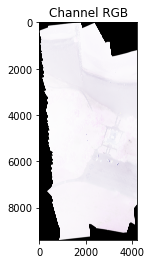

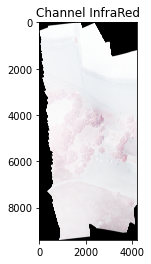

In [37]:
vmin = np.min(rgb_data_train)
vmax = np.max(rgb_data_train)

plt.imshow(rgb_data_train, cmap='viridis', vmin=vmin, vmax=vmax)  # Using 'viridis' colormap for better visualization
plt.title(f'Channel RGB')

plt.show()

vmin = np.min(infra_data_train)
vmax = np.max(infra_data_train)

plt.imshow(infra_data_train, cmap='hot', vmin=vmin, vmax=vmax)  # Using 'hot' colormap for better visualization
plt.title(f'Channel InfraRed')

plt.show()

In [38]:
print(rgb_data_test.shape)

(9393, 1412, 3)


In [39]:
model.fit(rgb_data_train,x_train_labels)
predictions_rgb = model.predict(rgb_data_test)
accuracies["Accuracy for spectra RGB"] = accuracy(predictions_rgb, x_test_labels)

<ipython-input-11-0bae2b4de62e>:39: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(self.calculate_likelihood(X, mean, std))


In [40]:
unique, counts = np.unique(predictions_rgb, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5966225, 1: 395535, 2: 1696544, 4: 6334, 6: 3027624, 8: 2170599, 9: 55}


In [41]:
model.fit(infra_data_train,x_train_labels)
predictions_infra = model.predict(infra_data_test)
accuracies["Accuracy for spectra InfraRed"] = accuracy(predictions_infra, x_test_labels)

<ipython-input-11-0bae2b4de62e>:39: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(self.calculate_likelihood(X, mean, std))


In [42]:
unique, counts = np.unique(predictions_infra, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5966226, 1: 1197553, 2: 2060210, 4: 404, 6: 931421, 8: 3107102}


### Using All Spectras

In [43]:
model.fit(x_train, x_train_labels)
preds = model.predict(x_test)
accuracies["Accuracy for spectra ALL"] = accuracy(preds, x_test_labels)

<ipython-input-11-0bae2b4de62e>:39: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(self.calculate_likelihood(X, mean, std))


In [44]:
unique, counts = np.unique(preds, return_counts=True)
print(dict(zip(unique, counts)))

{0: 5966225, 1: 663415, 2: 1334947, 3: 15695, 4: 6390, 5: 9, 6: 3155476, 8: 2115499, 9: 5260}


### Accuracy of Each Configuration

In [46]:
for key,value in accuracies.items():
    print(key, value)

Accuracy for spectra 1 0.9477863389921191
Accuracy for spectra 2 0.9306453874849241
Accuracy for spectra 3 0.9389389784267653
Accuracy for spectra 4 0.9581609202682125
Accuracy for spectra 5 0.9714185176170912
Accuracy for spectra 6 0.972001074273561
Accuracy for spectra RGB 0.9384067726886003
Accuracy for spectra InfraRed 0.9674442935475125
Accuracy for spectra ALL 0.971330150926086


# REPORT

## Problem Overview

The main thing in this assignment was to classify satellite images that has 6 channel using gaussian naive bayes classifier, but also doing this classification pixel by pixel. This process is called semantic segmentation and this semantic segmentation is integrated into classifier model. Then, making prediction in different scenarios such as using each spectra, using some spectras or using all spectras. After that calculating the accuracy of the model for each scenario so that the effect of the spectras can be understood better.

## Results and Analysis

According to the accuracy result, it can be said that the model is very well. But this result may be came from the image masking method. Because image masking turns black part into 0's and for the model it kind of becomes a memorized part. This increase accuracy.

<br>
Generally, the accuracy results are close, but the best accuracies are came from spectra 6 and all spectra. It can be said that the infrared spectras are more correlated or contains more info than RGB channels. 


## Approaches

* The first step was to applying mask to the image. This was the part that was most challanging. There were many different approaches tried and not so sure to the currently used one but here are some of the other approaches: <br>
train_data = train_data - train_mask[:, :, np.newaxis] <br>   
row_indices, col_indices = np.where(train_mask != 0)                                           
result_image_array = train_data[row_indices,col_indices, :] <br> <br>
new_train = [] <br>
for i in range(train_data.shape[2]): <br>
masked_arr = np.where(train_data[:,:,i],train_mask!=0)<br>
new_train.append(masked_arr)<br>
new_train = np.array(new_train)<br>
new_train = np.transpose(new_train, (1, 2, 0))<br> <br>

* Then GNB class is implemented, because we re doing naive bayes classification, we get standard deviation and the mean for each class while fitting the data. After, likelihood function is implemented according to the formula and for getting the prior probabilities the calculate_prior function is implemented. After that, using all these functions, prediction function is implemented the aim is to finding the value that maximizes the probability of the data. <br><br>

* After the implementation of GNB, it was time to use model on the wanted parts of the data. Data is splitted using numpy or other python arraylist operations. <br><br>

* Lastly accuracies are calculated. The approach for the calculation of the accuracy is acting like it is a binary classification problem. Because True Negative or False Negative terms are become unclear in multiclass. So I decided to proceed with calculating TP, TN,FP, FN values for each class and get the overall accuracy from them. Since the accuracies are too high, I am suspicious about if this is the true approach or the masking process is wrong.